usare el ambiente virtual de el curso 44.5: 
"../../44.5_films-ml-model-deployment/venv/Scripts/activate.bat"

Todo esto esta mejor explicado en el curso 17 y en el master de IA

# 1 PCA and IPCA

In [1]:
import pandas as pd
from scipy.sparse.construct import random
import sklearn
import matplotlib.pyplot as plt

#decomposition tiene todos los algoritmos de reduccion de dimenciones 
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# lo usaremos para comparar IPCA vs PCA
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## cargamos y preprocesammos data 

In [3]:
df_heart = pd.read_csv('./datasets/heart.csv')
df_heart.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0


In [7]:
X = df_heart.drop(['target'], axis=1)   # df_features
y = df_heart['target'] # df_target

# Normalizamos los datos
df_features = StandardScaler().fit_transform(X) 

# Partimos el conjunto de entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42) # para replicar
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(717, 13) (308, 13) (717,) (308,)


## entrenamiento 
1. comprararemos PCA normal y el IPCA(recomendado para bajo procesmiento)
2. evaluaremos la reduccion de dimensiones pasando  la data comprimida en un modelo de regresion logistica
3. revisaremos la relacion entre n_components(parametro principal del PCA) vs accuracy del modelo de regresion logistica.
4. analizaremos directamente cuanto 


In [19]:

# Configuracion de la regresión logística
logistic = LogisticRegression(solver='lbfgs') # el solver es standar 

pca_data = {'accuracy': [],
            'n_components': []}
ipca_data = {'accuracy': [],
            'n_components': []}
# PCA
for n in range(1, 14):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    df_train = pca.transform(X_train)
    df_test = pca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    
    pca_data['accuracy'].append(acccuracy)
    pca_data['n_components'].append(n)

# IPC
for n in range(1, 14):
    ipca = IncrementalPCA(n_components=n, 
                        batch_size=14) # manda los datos bloques de 10, optimiza procesamiento 
    ipca.fit(X_train)
    df_train = ipca.transform(X_train)
    df_test = ipca.transform(X_test)
    logistic.fit(df_train, y_train)
    acccuracy = logistic.score(df_test, y_test)
    
    ipca_data['accuracy'].append(acccuracy)
    ipca_data['n_components'].append(n)

    

c:\Users\Panda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Panda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

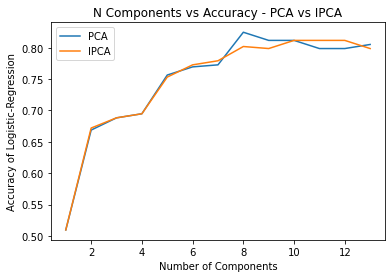

In [20]:
plt.plot(pca_data['n_components'], pca_data['accuracy'], label='PCA')
plt.plot(ipca_data['n_components'], ipca_data['accuracy'], label='IPCA')
plt.title('N Components vs Accuracy - PCA vs IPCA')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy of Logistic-Regression')
plt.legend()
plt.show()

la grafica tiene sentido ya que si intentamos comprimir 13 columnas en solo 1(n_components=1) habra mucha perdida de informacion, vemos que cuando tenemos 2 columnas el modelo da un salto de .50 a .65 lo que nos dice que el dataset de traning tiene mas informacion. vemos que modelo a partir de 2 componentes comienza a subir la coantidad de informacion util suministrada al modelo para realizar predicciones, hasta que llega a 8 componentes donde se atasca. 
### conclucion 
n_components=8 es el ideal para aportar la informacion necesaria para que el modelo pueda sacar el mejor uso de los datos.   
se podria decir que pasamos de tener 13 columnas de informacion a solo tener 8. asi estamos acelerando el timepo de entrenamiento ya que estamos usando solo la informacion que es importante para nuestro modelo,. 

(717, 13) (717, 3)


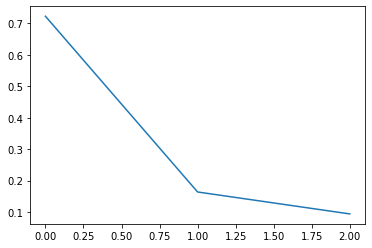

In [25]:

pca = PCA(n_components=3)
pca.fit(X_train)
df_train = pca.transform(X_train)
print(X_train.shape, df_train.shape)
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.show()

la grafica nos indica que el PC1(componente principal 1) localizada en x=0 aporta el 70% de la informacion del dataset, PC2 aporta solo el 20% y un PC =3 aporta 10%. 
ten en consideracion que estamos diciendo que el vector PC1 recoge el 70% de la varianza del dataset, la mayor cantidad. ver imagen del Mis apuntes curso 17 para entender mas. 

# 2 KPCA

In [29]:
from sklearn.decomposition import KernelPCA


logistic = LogisticRegression(solver='lbfgs')
# KPCA
kpca = KernelPCA(n_components=4, kernel='poly') # aplicamos un kernel polinomial 
kpca.fit(X_train)

# Configuramos los datos de entrenamiento con PCA
df_train = kpca.transform(X_train)
df_test = kpca.transform(X_test)

# Entrenando algoritmo de KPCA
# Entrenamos la regresion logistica con datos del PCA
logistic.fit(df_train, y_train)
# Calculamos nuestra exactitud de nuestra predicción
print('Score/Accuracy KPCA: ', logistic.score(df_test, y_test))

Score/Accuracy KPCA:  0.6818181818181818
